In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio
import statsmodels
import statsmodels.tsa.api as sm
import statsmodels.api as st
from statsmodels.tsa.stattools import adfuller, coint
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from itertools import combinations
from tinkoff.invest import Client
import requests
import apimoex
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/kirillshmelev/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
def hist_price(ticker_list, start):
    dataframes = []  # List to store individual DataFrames

    with requests.Session() as session:
        for ticker in ticker_list:
            #temp = apimoex.get_market_candles(session, ticker, 24, start)
            temp = apimoex.get_market_candles(session, ticker, market='index', engine='stock', interval = 24, start = start)
            df = pd.DataFrame(temp)
            #df.set_index('begin', inplace=True)  # Set the datetime column as the index
            #df.rename(columns={'close': ticker}, inplace=True)  # Rename 'open' column to ticker symbol
            df.rename(columns={'begin': 'Date'}, inplace=True)  # Rename 'open' column to ticker symbol
            dataframes.append(df)
            df['Date'] = pd.to_datetime(df['Date'])
            print(f'done for {ticker}')
    # Concatenate individual DataFrames into a single DataFrame
    hist = pd.concat(dataframes, axis=1)

    return hist

In [ ]:
def calculate_vt(df, period=20, percentile = 50):
    vt_list = []
    for start in range(0, len(df), period):
        end = start + period
        if end > len(df):
            end = len(df)
        median_volatility = df['vol_10d'][start:end].median()
        vt_list.append(np.percentile(median_volatility, percentile))
    return vt_list

In [ ]:
bonds = pd.read_csv('gazp.csv', sep = ';')
si = pd.read_csv('si.csv', sep = ';')
cb = pd.read_csv('usdcb.csv', sep = ';')

In [ ]:
cb

In [ ]:
data = bonds

In [ ]:
data = pd.merge(
    bonds,
    si[['<DATE>' ,'<TIME>','<CLOSE>']],
    on = ['<DATE>' ,'<TIME>'],
    how ='left'
)

In [ ]:
data = pd.merge(
    data,
    cb[['<DATE>' ,'<CLOSE>']],
    on = ['<DATE>'],
    how ='left'
)

In [ ]:
cb

In [ ]:
data

In [ ]:
data.dropna(inplace = True)

In [ ]:
data

In [ ]:
data.rename(columns={'<CLOSE>_x': 'px'}, inplace = True)
data.rename(columns={'<CLOSE>_y': 'SI'}, inplace = True)
data.rename(columns={'<CLOSE>': 'cbr'}, inplace = True)

In [ ]:
data['SI'] = data['SI']/1000

In [ ]:
data['<DATE>'] <= 250319

In [ ]:
data['<DATE>'] = pd.to_datetime(data['<DATE>'],format='%y%m%d')

In [ ]:
data['SI'] = data['SI']/1000
data['<DATE>'] = pd.to_datetime(data['<DATE>'],format='%y%m%d')
cutoff_date = pd.to_datetime('250319', format='%y%m%d')  # 25-Mar-2019
end_date1 = pd.to_datetime('250319', format='%y%m%d')    # 25-Mar-2019
end_date2 = pd.to_datetime('250619', format='%y%m%d')    # 25-Jun-2019

# Calculate day differences
data['days'] = np.where(data['<DATE>'] <= cutoff_date,
                        (end_date1 - data['<DATE>']).dt.days,
                        (end_date2 - data['<DATE>']).dt.days)

In [ ]:
cutoff_date = pd.to_datetime('250319', format='%y%m%d')  # 25-Mar-2019
end_date1 = pd.to_datetime('250319', format='%y%m%d')    # 25-Mar-2019
end_date2 = pd.to_datetime('250619', format='%y%m%d')    # 25-Jun-2019

# Calculate day differences
data['days'] = np.where(data['<DATE>'] <= cutoff_date,
                        (end_date1 - data['<DATE>']).dt.days,
                        (end_date2 - data['<DATE>']).dt.days)

In [ ]:
data

In [ ]:
data['rate'] = (data['SI']/data['cbr'] - 1)/data['days'] * 365

In [ ]:
(100/95-1) / 60 * 365

In [ ]:
data[data['rate']<-14.9]

In [ ]:
data.iloc[3100:]

In [ ]:
data1 = data.iloc[3100:]

In [ ]:
data1['rate'].mean()

In [ ]:
data1['rpx'] = data1['px']*data1['cbr']

In [ ]:
data1['rpx'].plot()

In [ ]:
data1['rate'].plot()

In [ ]:
data1['rpx_hedged'] = data1['SI']/data1['cbr']*data1['px']

In [ ]:
data1['rpx_hedged'].plot()

In [ ]:
df = str_test(data)

In [ ]:
df['cum'] = df['pl'] + 1
# Calculate daily returns
df['daily_returns'] = df['cum'].pct_change()

# Calculate volatility (standard deviation of daily returns)
volatility = df['daily_returns'].std() * np.sqrt(252)

# Calculate volatility-adjusted return (Sharpe Ratio can be considered a form of this)
df['vol_adjusted_return'] = df['cum'] / volatility

# Calculate running maximum of cumulative returns
df['running_max'] = df['cum'].cummax()

# Calculate drawdown
df['drawdown'] = df['running_max'] - df['cum']

# Calculate maximum drawdown
max_drawdown = df['drawdown'].max()

In [ ]:
df.drawdown.plot()

In [ ]:
print('max drawdown: '  + str(max_drawdown))
print('vol adjusted return: ' + str(df['vol_adjusted_return'].iloc[-2]))


In [ ]:
plt.plot(df['norm_p']-1 , label='normalized price')
plt.plot(df['pl'], label='Perfomance')
plt.legend()
print('annualized perfomance:' + str(100 * ((1+df['pl'].iloc[-2]) ** (1/(len(df)/252)) - 1)))

In [ ]:
df[['pl','norm_p']]

In [ ]:
df['funding_long'].sum()

In [ ]:
df['position'].plot()

In [ ]:
df['cum'].plot()

In [ ]:
df.position.plot()

In [ ]:
df['funding_short'].sum()

In [ ]:
df['pl'].iloc[-2]

In [ ]:
(1+df['pl'].iloc[-2]) ** (1 / (len(df)/252))-1

In [ ]:
result = pd.DataFrame(columns = ['tickers', 'asset_perf', 'str_perf'])

In [ ]:
plt.plot(df['close'] , label='close')
plt.plot(df['ma_5'], label='ma_5')
plt.plot(df['ma_20'], label='ma_20')
plt.legend()
plt.show()

In [ ]:
today = datetime.today()
days_ago = today - timedelta(days=3000)
start = days_ago
data = hist_price(['IMOEX'], start)

In [ ]:
def tester(tickers):
    result = pd.DataFrame(columns = ['tickers', 'start', 'asset_perf', 'str_perf', 'diff'])
    excel_data = pd.ExcelFile('RC.xlsx')
    sheet_names = excel_data.sheet_names
    rate = excel_data.parse(sheet_names[0])
    rate.rename(columns={'6 месяцев': 'Rate', 'Дата': 'Date' }, inplace=True)
    rate['Rate'] = rate['Rate'] / 100
    columns_to_drop = ['Индекс', '1 месяц', '3 месяца']  
    rate = rate.drop(columns=columns_to_drop)
    for ticker in tickers:
        print(1)
        today = datetime.today()
        days_ago = today - timedelta(days=1000)
        start = days_ago.strftime("%Y-%m-%d")
        data = pd.DataFrame()
        print(2)
        data = hist_price([ticker], start)
        print(3)
        data['close_chg'] = data['close'].pct_change()
        data['vol_10d'] = data['close_chg'].rolling(window = 10).std() * np.sqrt(252) * 100
        data.reset_index(inplace = True)
        vt = calculate_vt(data)
        data['vt'] = 0
        for i, vt in enumerate(vt):
            start = (i+1) * 122
            end = start + 122
            if end > len(data):
                end = len(data)
            data.loc[start:end, 'vt'] = vt
        
        data = pd.merge(data, rate[['Date', 'Rate']], on='Date', how='left')
        df = str_test(data)
        ba_perf = df['norm_p'].iloc[-2] ** (1/(len(df)/252)) -1 
        str_perf = ((1+df['pl'].iloc[-2]) ** (1/(len(df)/252)) - 1)
        result.loc[len(result)] = [ticker, data['Date'][122], ba_perf, str_perf, str_perf - ba_perf]
        plt.plot(df['norm_p']-1 , label='normalized price')
        plt.plot(df['pl'], label='Perfomance')
        plt.title(ticker)
        plt.legend()
        plt.show()
        
        #time.sleep(1)
    return result

In [ ]:
tickers = ['SBMX', 'ALRS', 'CHMF', 'GAZP', 'GMKN', 'LKOH', 'MAGN', 'MGNT', 'NLMK', 'NVTK', 'PLZL', 'ROSN', 'SBER', 'SNGS', 'TATN', 'TCSG']

In [ ]:
res = tester(tickers)

In [ ]:
res

In [ ]:
df.iloc[120:]

In [ ]:
df['norm_p'].iloc[-2] ** (1/(len(df)/252)) -1 

In [ ]:
data

In [ ]:
df.position.plot()

In [ ]:
df.norm_p.plot()

In [ ]:
df.pl.plot()

In [ ]:
(df['norm_p']-1).plot()

In [ ]:
data['vol_10d'].plot()

In [ ]:
data['close'].plot()

In [ ]:
(abs(df.position - df.position.shift())).plot()

In [ ]:
(abs(df.position - df.position.shift())).sum()

In [ ]:
(283*0.0004)/(2000/365)

New try

In [2]:
bonds = pd.read_csv('gazp.csv', sep = ';')
si = pd.read_csv('si.csv', sep = ';')
cb = pd.read_csv('usdcb.csv', sep = ';')

In [3]:
cb

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,USDCB,1,250110,0,102.2911,102.2911,102.2911,102.2911,0
1,USDCB,1,250111,0,101.9146,101.9146,101.9146,101.9146,0
2,USDCB,1,250114,0,102.7081,102.7081,102.7081,102.7081,0
3,USDCB,1,250115,0,103.4380,103.4380,103.4380,103.4380,0
4,USDCB,1,250116,0,102.8078,102.8078,102.8078,102.8078,0
...,...,...,...,...,...,...,...,...,...
67,USDCB,1,250415,0,82.7671,82.7671,82.7671,82.7671,0
68,USDCB,1,250416,0,82.3003,82.3003,82.3003,82.3003,0
69,USDCB,1,250417,0,82.5892,82.5892,82.5892,82.5892,0
70,USDCB,1,250418,0,82.0200,82.0200,82.0200,82.0200,0


In [4]:
data = pd.merge(
    bonds,
    si[['<DATE>' ,'<TIME>','<CLOSE>']],
    on = ['<DATE>' ,'<TIME>'],
    how ='left'
)

data = pd.merge(
    data,
    cb[['<DATE>' ,'<CLOSE>']],
    on = ['<DATE>'],
    how ='left'
)


data.rename(columns={'<CLOSE>_x': 'px'}, inplace = True)
data.rename(columns={'<CLOSE>_y': 'SI'}, inplace = True)
data.rename(columns={'<CLOSE>': 'cbr'}, inplace = True)

data['SI'] = data['SI']/1000
data['<DATE>'] = pd.to_datetime(data['<DATE>'],format='%y%m%d')
cutoff_date = pd.to_datetime('250319', format='%y%m%d')  # 25-Mar-2019
end_date1 = pd.to_datetime('250319', format='%y%m%d')    # 25-Mar-2019
end_date2 = pd.to_datetime('250619', format='%y%m%d')    # 25-Jun-2019

# Calculate day differences
data['days'] = np.where(data['<DATE>'] <= cutoff_date,
                        (end_date1 - data['<DATE>']).dt.days,
                        (end_date2 - data['<DATE>']).dt.days)

In [5]:
data

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,px,<VOL>,SI,cbr,days
0,RU000A105RG4,1,2025-01-03,102100,96.3430,96.3430,96.3430,96.3430,1,105.581,NaN,75
1,RU000A105RG4,1,2025-01-03,102600,96.5560,96.5940,96.5560,96.5940,2,105.828,NaN,75
2,RU000A105RG4,1,2025-01-03,102900,96.9199,96.9199,96.9199,96.9199,2,105.747,NaN,75
3,RU000A105RG4,1,2025-01-03,103400,96.5349,96.5349,96.5349,96.5349,1,105.602,NaN,75
4,RU000A105RG4,1,2025-01-03,103500,96.5348,96.5348,96.5348,96.5348,10,105.613,NaN,75
...,...,...,...,...,...,...,...,...,...,...,...,...
5932,RU000A105RG4,1,2025-04-18,224800,99.4465,99.4465,99.4465,99.4465,1,85.042,82.02,62
5933,RU000A105RG4,1,2025-04-18,225100,99.6102,99.6102,99.6102,99.6102,1,85.002,82.02,62
5934,RU000A105RG4,1,2025-04-18,230200,99.6102,99.6102,99.6102,99.6102,1,84.977,82.02,62
5935,RU000A105RG4,1,2025-04-18,230600,99.6102,99.6102,99.6102,99.6102,1,84.971,82.02,62


In [24]:
data['bond_returns'] = data['px'].pct_change()

In [25]:
data['fx_returns'] = data['SI'].pct_change()

In [26]:
data.dropna(inplace = True)

In [27]:
import pandas as pd
import numpy as np
from scipy.signal import correlate


# Compute cross-correlation
cross_corr = correlate(data['bond_returns'], data['fx_returns'], mode='full')
lags = np.arange(-len(data)+1, len(data))
optimal_lag = lags[np.argmax(cross_corr)]  # Lag with highest correlation

print(f"Bonds lag FX by {optimal_lag} periods")

Bonds lag FX by 0 periods


<Axes: >

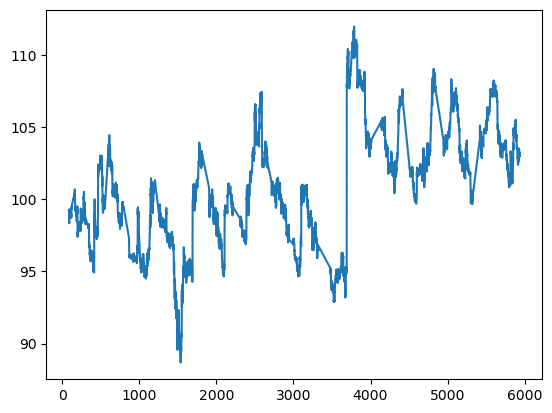

In [31]:
(data['px']*data['SI']/data['cbr']).plot()

<Axes: title={'center': 'Unexplained Bond Returns (Alpha)'}>

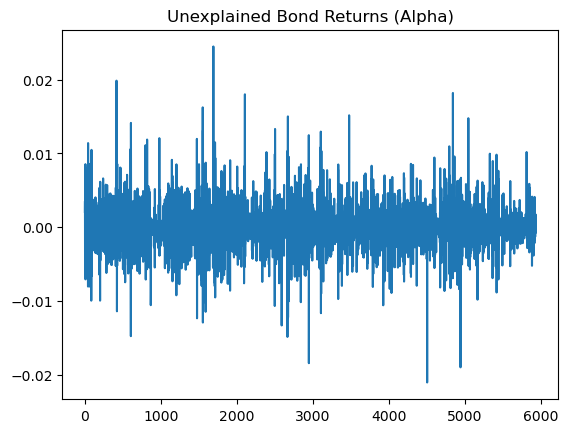

In [10]:
from sklearn.linear_model import LinearRegression

# Fit bond returns vs. lagged FX returns
X = data['fx_returns'].shift(-optimal_lag).dropna().values.reshape(-1, 1)  # Lag-adjusted FX
y = data['bond_returns'].iloc[:len(X)].values  # Align bond returns

model = LinearRegression().fit(X, y)
data['predicted_bond'] = model.predict(X.reshape(-1, 1))
data['residuals'] = y - data['predicted_bond']  # "New" bond moves

# Plot residuals
data['residuals'].plot(title='Unexplained Bond Returns (Alpha)')

In [12]:
std_dev = data['residuals'].std()
data['signal'] = np.where(data['residuals'] > std_dev, 1, 0)  # Buy bonds on "new" FX shocks

In [13]:
data

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,px,<VOL>,SI,days,bond_returns,fx_returns,predicted_bond,residuals,signal
1,RU000A105RG4,1,2025-01-03,102600,96.5560,96.5940,96.5560,96.5940,2,105.828,75,0.002605,0.002339,5.254395e-04,2.079835e-03,0
2,RU000A105RG4,1,2025-01-03,102900,96.9199,96.9199,96.9199,96.9199,2,105.747,75,0.003374,-0.000765,-1.517472e-04,3.525663e-03,1
3,RU000A105RG4,1,2025-01-03,103400,96.5349,96.5349,96.5349,96.5349,1,105.602,75,-0.003972,-0.001371,-2.838777e-04,-3.688475e-03,0
4,RU000A105RG4,1,2025-01-03,103500,96.5348,96.5348,96.5348,96.5348,10,105.613,75,-0.000001,0.000104,3.790988e-05,-3.894578e-05,0
5,RU000A105RG4,1,2025-01-03,103900,96.8491,96.8491,96.8491,96.8491,2,105.563,75,0.003256,-0.000473,-8.806714e-05,3.343888e-03,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932,RU000A105RG4,1,2025-04-18,224800,99.4465,99.4465,99.4465,99.4465,1,85.042,62,-0.000436,0.001566,3.568307e-04,-7.930559e-04,0
5933,RU000A105RG4,1,2025-04-18,225100,99.6102,99.6102,99.6102,99.6102,1,85.002,62,0.001646,-0.000470,-8.739739e-05,1.733509e-03,0
5934,RU000A105RG4,1,2025-04-18,230200,99.6102,99.6102,99.6102,99.6102,1,84.977,62,0.000000,-0.000294,-4.895700e-05,4.895700e-05,0
5935,RU000A105RG4,1,2025-04-18,230600,99.6102,99.6102,99.6102,99.6102,1,84.971,62,0.000000,-0.000071,-2.092196e-07,2.092196e-07,0


In [14]:
data['spread'] = data['bond_returns'] - data['fx_returns']
window = 20
data['spread_ma'] = data['spread'].rolling(window).mean()
data['spread_std'] = data['spread'].rolling(window).std()
data['upper_band'] = data['spread_ma'] + data['spread_std']
data['lower_band'] = data['spread_ma'] - data['spread_std']

In [15]:
# 4. Entry Signals
data['signal'] = np.where(
    data['spread'] > data['upper_band'], 
    1,  # Buy bond, short futures
    np.where(
        data['spread'] < data['lower_band'], 
        -1,  # Sell bond, long futures
        0
    )
)

data['position'] = 0  # Initialize
active_position = 0
for i in range(1, len(data)):
    # Open new position if no active trade and signal exists
    if active_position == 0 and data['signal'].iloc[i] == 1:
        active_position = data['signal'].iloc[i]
    # Close position if spread converges or stop-loss hits
    elif active_position != 0:
        if (active_position == 1 and data['spread'].iloc[i] <= data['spread_ma'].iloc[i]) or 
          # (active_position == -1 and data['spread'].iloc[i] >= data['spread_ma'].iloc[i]) or \
           #(abs(data['spread'].iloc[i]) > 2 * data['spread_std'].iloc[i]):  # Stop-loss
            active_position = 0
    data['position'].iloc[i] = active_position

# 6. P&L Calculation
data['bond_pnl'] = data['px'].diff() * data['position'].shift(1)
data['futures_pnl'] = -data['SI'].diff() * data['position'].shift(1)  # Short hedge
data['total_pnl'] = data['bond_pnl'].fillna(0) + data['futures_pnl'].fillna(0)
data['cumulative_pnl'] = data['total_pnl'].cumsum()

# Results
print(data[['spread', 'position', 'total_pnl', 'cumulative_pnl']].tail(10))

        spread  position  total_pnl  cumulative_pnl
5927 -0.000106         0     0.0000        -93.9732
5928  0.001364         0     0.0000        -93.9732
5929 -0.000721         0     0.0000        -93.9732
5930 -0.000097         0     0.0000        -93.9732
5931  0.000257         0     0.0000        -93.9732
5932 -0.002003         0    -0.0000        -93.9732
5933  0.002116         1     0.0000        -93.9732
5934  0.000294         1     0.0250        -93.9482
5935  0.000071         1     0.0060        -93.9422
5936  0.000050         1     0.0072        -93.9350


In [16]:
data[15:30]

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,px,<VOL>,SI,...,spread,spread_ma,spread_std,upper_band,lower_band,position,bond_pnl,futures_pnl,total_pnl,cumulative_pnl
16,RU000A105RG4,1,2025-01-03,203200,97.2000,97.2000,97.2000,97.2000,10,106.085,...,-0.003129,NaN,NaN,NaN,NaN,0,-0.0000,-0.000,-0.0000,0.0000
17,RU000A105RG4,1,2025-01-06,101300,97.2205,97.2205,97.2205,97.2205,4,105.934,...,0.001634,NaN,NaN,NaN,NaN,0,0.0000,0.000,0.0000,0.0000
18,RU000A105RG4,1,2025-01-06,102100,97.2204,97.2204,97.2204,97.2204,3,105.760,...,0.001642,NaN,NaN,NaN,NaN,0,-0.0000,0.000,0.0000,0.0000
19,RU000A105RG4,1,2025-01-06,104500,96.7048,96.7048,96.7047,96.7047,2,105.114,...,0.000804,NaN,NaN,NaN,NaN,0,-0.0000,0.000,0.0000,0.0000
20,RU000A105RG4,1,2025-01-06,113300,96.9945,96.9945,96.9945,96.9945,1,105.357,...,0.000685,0.000449,0.003980,0.004428,-0.003531,0,0.0000,-0.000,0.0000,0.0000
21,RU000A105RG4,1,2025-01-06,120000,96.9403,96.9403,96.9403,96.9403,1,105.081,...,0.002061,0.000538,0.003996,0.004534,-0.003457,0,-0.0000,0.000,0.0000,0.0000
22,RU000A105RG4,1,2025-01-06,130800,96.8000,96.8000,96.8000,96.8000,5,104.737,...,0.001826,0.000423,0.003919,0.004341,-0.003496,0,-0.0000,0.000,0.0000,0.0000
23,RU000A105RG4,1,2025-01-06,130900,96.7900,96.7900,96.7900,96.7900,5,104.752,...,-0.000247,0.000540,0.003858,0.004398,-0.003317,0,-0.0000,-0.000,-0.0000,0.0000
24,RU000A105RG4,1,2025-01-06,131200,96.3705,96.4000,96.3702,96.4000,9,104.623,...,-0.002798,0.000406,0.003928,0.004334,-0.003522,0,-0.0000,0.000,0.0000,0.0000
25,RU000A105RG4,1,2025-01-06,131500,96.4500,96.4500,96.4500,96.4500,2,104.564,...,0.001083,0.000273,0.003854,0.004127,-0.003581,0,0.0000,0.000,0.0000,0.0000


In [17]:
(data['SI']/data['CBR']).plot()

KeyError: 'CBR'

In [18]:
data.columns

Index(['<TICKER>', '<PER>', '<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>',
       'px', '<VOL>', 'SI', 'days', 'bond_returns', 'fx_returns',
       'predicted_bond', 'residuals', 'signal', 'spread', 'spread_ma',
       'spread_std', 'upper_band', 'lower_band', 'position', 'bond_pnl',
       'futures_pnl', 'total_pnl', 'cumulative_pnl'],
      dtype='object')

V.3

In [9]:
data.dropna(inplace = True)

In [32]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Tuple

@dataclass
class StrategyParams:
    roll_std: int = 60           # minutes used for rolling σ
    z_entry: float = 2.0         # open position when |z| > z_entry
    z_exit: float = 0.5          # flatten when |z| < z_exit
    bond_notional_usd: int = 1000 # face value of bond per trade (USD)
    contract_size: int = 1_000   # USD value per MOEX USD/RUB futures contract


def compute_signals(df: pd.DataFrame, p: StrategyParams) -> pd.DataFrame:
    """Add residual, z‑score and trading signals to *df* (does not mutate input)."""
    out = df.copy()

    # Lagged values
    out['px_prev'] = out['px'].shift(1)
    out['SI_prev'] = out['SI'].shift(1)

    # Expected price given latest FX move
    out['P_exp'] = out['px_prev'] + out['px_prev'] * (
        (out['SI'] - out['SI_prev']) / out['cbr']
    )

    # Residual and rolling σ
    out['residual'] = out['px'] - out['P_exp']
    out['res_std'] = out['residual'].rolling(p.roll_std, min_periods=p.roll_std).std()
    out['z'] = out['residual'] / out['res_std']

    # Generate discrete bond position
    pos = 0
    positions = []
    for z in out['z']:
        if np.isnan(z):
            positions.append(pos)
            continue
        if pos == 0:
            if z > p.z_entry:
                pos = 0  # short bond, long USD via futures TURNED IT OFF
            elif z < -p.z_entry:
                pos = 1   # long bond, short USD via futures
        else:  # already in a trade
            if abs(z) < p.z_exit:
                pos = 0   # flatten
        positions.append(pos)

    out['pos_bond'] = positions
    out['pos_fx'] = -out['pos_bond'] * (p.bond_notional_usd / p.contract_size)
    return out


def pnl_from_positions(df: pd.DataFrame, p: StrategyParams) -> pd.DataFrame:
    """Compute minute‑by‑minute PnL streams (RUB) from positions."""
    out = df.copy()

    # Bond PnL: Δprice (% of par) × USD face × CBR fixing
    out['bond_pnl'] = (
        out['pos_bond'].shift(1) * out['px'].diff() / 100 * p.bond_notional_usd * out['cbr']
    )

    # Futures PnL: position (contracts) × Δprice (RUB per USD) × contract_size
    out['fx_pnl'] = out['pos_fx'].shift(1) * out['SI'].diff() * p.contract_size

    out['pnl'] = out['bond_pnl'].fillna(0) + out['fx_pnl'].fillna(0)
    out['cum_pnl'] = out['pnl'].cumsum()
    return out


def backtest(df: pd.DataFrame, params: StrategyParams = None) -> pd.DataFrame:
    """Full pipeline: compute signals, apply PnL accounting, return annotated DataFrame."""
    if params is None:
        params = StrategyParams()
    sig = compute_signals(df, params)
    res = pnl_from_positions(sig, params)
    return res


def performance_summary(res: pd.DataFrame) -> pd.Series:
    """Quick performance KPIs returned as a Series."""
    pnl = res['pnl']
    ann_factor = 252 * 60 * 6.5  # ≈ number of 1‑min bars per trading year (6.5h session)
    mean = pnl.mean() * ann_factor
    vol = pnl.std(ddof=0) * np.sqrt(ann_factor)
    sharpe = mean / vol if vol != 0 else np.nan
    max_dd = (res['cum_pnl'].cummax() - res['cum_pnl']).max()
    return pd.Series({
        'Total PnL (RUB)': res['cum_pnl'].iloc[-1],
        'Ann. Sharpe': sharpe,
        'Max drawdown (RUB)': max_dd,
        'Trades': res['pos_bond'].diff().abs().sum() / 2,
    })




In [33]:
if __name__ == "__main__":
    # ---------------------------------------------------------------------
    # Example usage with synthetic data -----------------------------------
    # ---------------------------------------------------------------------


    results = backtest(data)
    print(performance_summary(results))

Total PnL (RUB)       22247.547481
Ann. Sharpe              13.461416
Max drawdown (RUB)     5496.993571
Trades                  117.000000
dtype: float64


In [69]:
117*0.00025*1000*82

2398.5

In [40]:
results.drop(['<TICKER>','<PER>','<OPEN>','<HIGH>','<LOW>','<VOL>', 'days'], axis = 1 , inplace = True)

<Axes: >

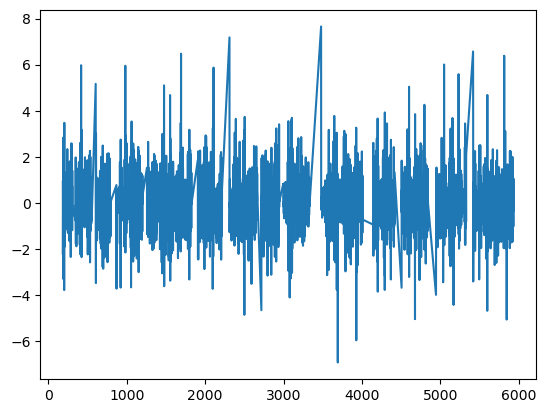

In [42]:
results['z'].plot()

In [50]:
bonds

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,RU000A105RG4,1,250103,102100,96.3430,96.3430,96.3430,96.3430,1
1,RU000A105RG4,1,250103,102600,96.5560,96.5940,96.5560,96.5940,2
2,RU000A105RG4,1,250103,102900,96.9199,96.9199,96.9199,96.9199,2
3,RU000A105RG4,1,250103,103400,96.5349,96.5349,96.5349,96.5349,1
4,RU000A105RG4,1,250103,103500,96.5348,96.5348,96.5348,96.5348,10
...,...,...,...,...,...,...,...,...,...
5932,RU000A105RG4,1,250418,224800,99.4465,99.4465,99.4465,99.4465,1
5933,RU000A105RG4,1,250418,225100,99.6102,99.6102,99.6102,99.6102,1
5934,RU000A105RG4,1,250418,230200,99.6102,99.6102,99.6102,99.6102,1
5935,RU000A105RG4,1,250418,230600,99.6102,99.6102,99.6102,99.6102,1


In [66]:
(-95.5615*10*102.7081+105.833*1000) + (96.0893*10*102.7081-105.924*1000)

451.0933517999947

In [65]:
(-95.5615+96.0893)/100*1000*105.833

558.5865739999991

In [60]:
results[60:90]

,<DATE>,<TIME>,px,SI,cbr,px_prev,SI_prev,P_exp,residual,res_std,z,pos_bond,pos_fx,bond_pnl,fx_pnl,pnl,cum_pnl
183,2025-01-14,141600,95.9160,106.165,102.7081,96.1676,105.970,96.350182,-0.434182,0.196424,-2.210436,1,-1.0,-0.000000,0.0,0.000000,0.000000
184,2025-01-14,145200,95.8373,106.114,102.7081,95.9160,106.165,95.868373,-0.031073,0.196276,-0.158311,0,0.0,-80.831275,51.0,-29.831275,-29.831275
185,2025-01-14,152300,95.9999,106.086,102.7081,95.8373,106.114,95.811173,0.188727,0.196493,0.960476,0,0.0,0.000000,-0.0,0.000000,-29.831275
186,2025-01-14,152400,96.0000,106.070,102.7081,95.9999,106.086,95.984945,0.015055,0.196222,0.076724,0,0.0,0.000000,-0.0,0.000000,-29.831275
187,2025-01-14,153000,95.8000,105.961,102.7081,96.0000,106.070,95.898119,-0.098119,0.170929,-0.574035,0,0.0,-0.000000,-0.0,-0.000000,-29.831275
188,2025-01-14,154100,96.1699,105.801,102.7081,95.8000,105.961,95.650762,0.519138,0.183841,2.823841,0,0.0,0.000000,-0.0,0.000000,-29.831275
189,2025-01-14,162600,96.1689,105.793,102.7081,96.1699,105.801,96.162409,0.006491,0.176559,0.036762,0,0.0,-0.000000,-0.0,-0.000000,-29.831275
190,2025-01-14,171100,95.5615,105.833,102.7081,96.1689,105.793,96.206353,-0.644853,0.194906,-3.308526,1,-1.0,-0.000000,0.0,0.000000,-29.831275
191,2025-01-14,175500,96.0893,105.924,102.7081,95.5615,105.833,95.646168,0.443132,0.203678,2.175644,1,-1.0,542.093352,-91.0,451.093352,421.262077
192,2025-01-14,181800,96.1000,105.964,102.7081,96.0893,105.924,96.126722,-0.026722,0.201946,-0.132324,0,0.0,10.989767,-40.0,-29.010233,392.251844
